## Section 1: Data Cleaning

### In this section we:
- Added text labels to csv dataset
- Pruned dataset to meet needs
- Created brightness augmentations using PIL

In [1]:
import os
from PIL import Image
import numpy as np
from collections import defaultdict
import pandas as pd
import matplotlib.pyplot as plt

In [2]:
# # don't run without train_images folder
# images = os.listdir()
# size_counts = defaultdict(int)
# def is_jpg(filename):
#     try:
#         i=Image.open(filename)
#         return i.format =='JPEG'
#     except IOError:
#         return False
# for i in range(len(images)-1, len(images)):
#     if not is_jpg(images[i]):
#         continue
#     im = Image.open(images[i])
#     size_counts[im.size]+=1
# size_counts = dict(size_counts)
# print(len(images), "images of size:", im.size)

## Read the csv as a dataframe and map number codes to the long label

### We declare a function that uses a manually created dictionary to the type of condition the data has

In [3]:
def numToLong(input):
    return {"0": "Cassava Bacterial Blight (CBB)", 
            "1": "Cassava Brown Streak Disease (CBSD)", 
            "2": "Cassava Green Mottle (CGM)", 
            "3": "Cassava Mosaic Disease (CMD)", 
            "4": "Healthy"}[str(input)]
np.random.seed(42)
df = pd.read_csv('./train.csv')
df['long_labels'] = df.label.map(lambda x: numToLong(x))
df.shape 

(5153, 3)

## Remove extra images from train_images folder

We want the data to be balanced between sick and not sick so we have roughly 2500 healthy images and ~500 of each disease in our final dataset for this project

In [4]:
remove_amounts = [x-2577//4 if x!=2577 else 0 for x in list(df.long_labels.value_counts())]
rm_dict = {0:remove_amounts[4],1:remove_amounts[2],2:remove_amounts[3],3:remove_amounts[0]}

df_pruned = df.copy() 
for i in [0,1,2,3]:
    frac = rm_dict[i]/df_pruned[df_pruned['label']==i].count()[0]
    print("removing ", df_pruned[df_pruned['label']==i].count()[0], numToLong(i))
    df_pruned = df_pruned.drop(df_pruned[df_pruned['label'] == i].sample(frac=frac).index)
df_pruned.long_labels.value_counts().plot.bar()

df_pruned.to_csv('train.csv',index=False)

df_remove_from_train_images = df[~df.isin(df_pruned)].dropna()

images_dir= "../../cassava-leaf-disease-classification/train_images/"
count = 0
#run this inside of train_images folder to actually delete the images.
for i in df_remove_from_train_images['image_id'].values:
    if os.path.exists(images_dir+i):
        count += 1
    else:
        print(i, "does not exist")

removing  644 Cassava Bacterial Blight (CBB)


ValueError: A negative number of rows requested. Please provide positive value.

In [5]:
images_dir= "../../cassava-leaf-disease-classification/train_images/"
count = 0
print(len(os.listdir(images_dir)), count)

21398 0


## We are of the opinion that most of the images in the train dataset are in well-lit conditions that aren't realistic to every possible farmer's situation. 

We have decided to create an augmentation that randomizes the brightness setting of the images.

NameError: name 'im' is not defined

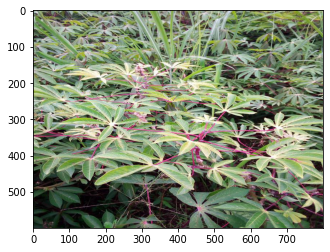

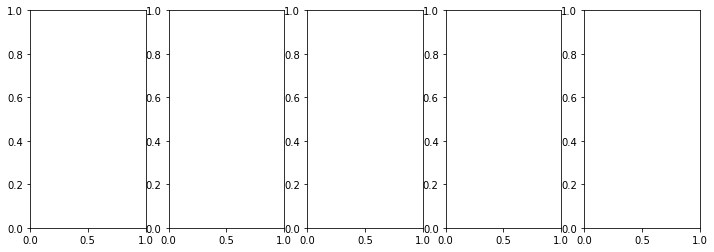

In [6]:
from PIL import Image, ImageEnhance


cas = "../../cassava-leaf-disease-classification/test_images/2216849948.jpg"

plt.imshow(plt.imread("../../cassava-leaf-disease-classification/test_images/2216849948.jpg"))
                
fig, axs = plt.subplots(1,5,figsize=(12,4))

enhancer = ImageEnhance.Brightness(im)
im.show()

for change, ax in zip(np.linspace(-0.5, 0.5,5), axs):
    im_output = enhancer.enhance(1+change)
    print(change)
    im_output.show( title=f'change={change:.2f}')

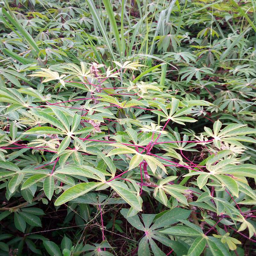

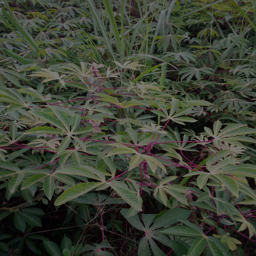

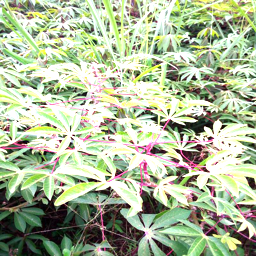

In [7]:
from IPython.display import display
from PIL import Image, ImageEnhance

#read the image
im = Image.open(cas).resize((256,256))

#image brightness enhancer
enhancer = ImageEnhance.Brightness(im)

factor = 1 #gives original image
im_output = enhancer.enhance(factor)
display(im_output)

factor = 0.5 #darkens the image
im_output = enhancer.enhance(factor)
display(im_output)

factor = 1.5 #brightens the image
im_output = enhancer.enhance(factor)
display(im_output)

-0.5
-0.25
0.0
0.25
0.5


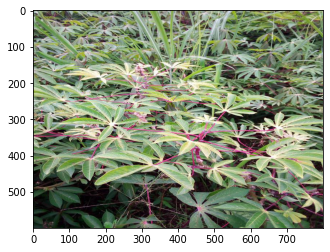

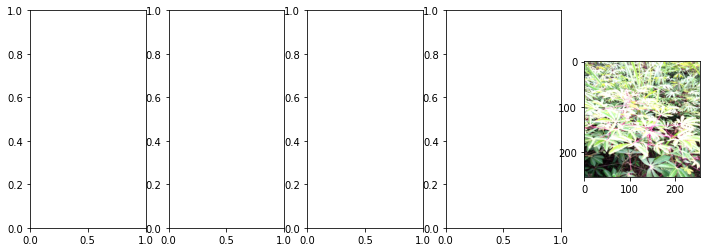

In [8]:
from PIL import Image, ImageEnhance
from IPython.display import display

cas = "../../cassava-leaf-disease-classification/test_images/2216849948.jpg"
enhancer = ImageEnhance.Brightness(im)

im.show()

plt.imshow(plt.imread(cas))

fig, axs = plt.subplots(1,5,figsize=(12,4))

for change, ax in zip(np.linspace(-0.5, 0.5,5), axs):

    im_output = enhancer.enhance(1+change)
    print(change)
    factor+1
    plt.imshow(im_output)
    im_output.show(title=f'change={change:.2f}')

# Section 3a: Data Modelling 
## In this section: EfficientNet
- image augmentation 
- step 1: data loaders set up 
- step 2: modelling and initial training 

In [9]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from matplotlib import style
import seaborn as sns
%matplotlib inline  
from sklearn.model_selection import StratifiedKFold
from joblib import load, dump
from sklearn.metrics import cohen_kappa_score
from sklearn.metrics import confusion_matrix
from fastai import *
from fastai.vision import *
from fastai.vision.data import ImageDataLoaders
from fastai.vision.augment import aug_transforms
import fastai.callback.all
from torchvision import models as md
from efficientnet_pytorch import EfficientNet
from pathlib import Path
from torchvision.utils import make_grid
from sklearn.metrics import log_loss
import os
BS = 64
SZ = 224
images_dir= "../../cassava-leaf-disease-classification/train_images/"
df = pd.read_csv('./train.csv')

print(df.shape)
def file_exists(file):
    return os.path.exists(images_dir+file)

df['exists'] = df['image_id'].apply(lambda x: file_exists(x))
df=df[df['exists']]

def is_healthy(number):
    if number==4:
        return 1 #healthy
    else:
        return 0 #is_sick
df['is_healthy'] = df['label'].apply(lambda x: is_healthy(x))
df['is_healthy']

(5153, 3)


0       1
1       0
2       0
3       1
4       0
       ..
5148    0
5149    0
5150    0
5151    1
5152    1
Name: is_healthy, Length: 5153, dtype: int64

In [10]:
tfms = aug_transforms(do_flip=True, 
                      flip_vert=True,
                      max_rotate=360,
                      max_zoom=False, 
                      max_lighting=0.1,
                      p_lighting=0.5,
                      xtra_tfms= None)

In [11]:
from sklearn.model_selection import StratifiedKFold

FOLD = 4

def strt_split(x, y, n_folds=5, random_seed = 42, path=Path('')):  
    try: 
        val_name = load('val_idx.joblib')
    except:
        skf = StratifiedKFold(n_splits=n_folds, shuffle=True, random_state=random_seed)
        val_name = [(val_idx, trn_idx) for trn_idx, val_idx in skf.split(x, y)]
        dump(val_name,'val_idx.joblib')
    return val_name

In [12]:
from fastai.vision.all import *
dls = ImageDataLoaders.from_df(df=df, path=Path(images_dir), cols='image', valid_pct=0.3, label_col=4, batch_tfms=Normalize.from_stats(*imagenet_stats), bs=BS, val_bs=16)
#         .label_from_df(cols='is_healthy', label_cls=FloatList)
#         .transform(tfms,size=SZ) #Data augmentation
#         .databunch(bs=BS)
#         .normalize(imagenet_stats)

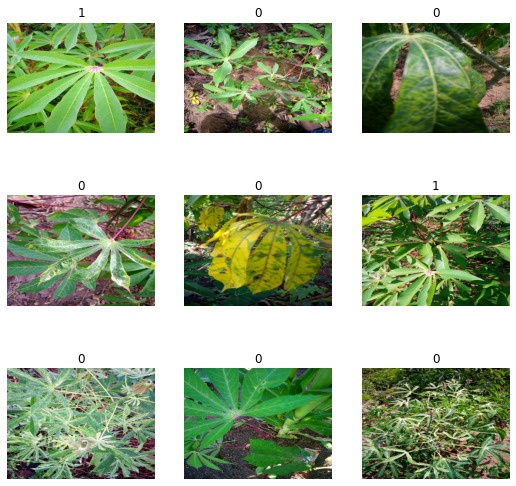

In [13]:
# data.classes
# data.show_batch(x=3, y=3, samples=)
# def show_images(images, nmax=64):
#     fig, ax = plt.subplots(figsize=(8, 8))
#     ax.set_xticks([]); ax.set_yticks([])
#     ax.imshow(make_grid((images.detach()[:nmax]), nrow=8).permute(1, 2, 0))
# def show_batch(dl, nmax=64):
#     for images in dl:
#         show_images(images, nmax)
#         break
# show_batch(data.train)
dls.train.show_batch()

In [14]:
from fastai.losses import CrossEntropyLossFlat
md_ef =  EfficientNet.from_pretrained('efficientnet-b4', num_classes=1)

learn = Learner(dls, md_ef, metrics = [log_loss], model_dir="models")
learn.model = nn.DataParallel(learn.model)
learn.to_fp16()
learn.unfreeze()

Loaded pretrained weights for efficientnet-b4


In [15]:
lr = 5e-2

In [16]:
learn = cnn_learner(dls, resnet18, metrics=[error_rate])

In [17]:
learn.lr_find()

RuntimeError: CUDA out of memory. Tried to allocate 236.00 MiB (GPU 0; 10.92 GiB total capacity; 9.86 GiB already allocated; 177.44 MiB free; 10.07 GiB reserved in total by PyTorch)

In [18]:
learn.fit_one_cycle(5,
                    lr)

epoch,train_loss,valid_loss,error_rate,time


Traceback (most recent call last):
  File "/usr/lib/python3.8/multiprocessing/util.py", line 300, in _run_finalizers
    finalizer()
  File "/usr/lib/python3.8/multiprocessing/util.py", line 224, in __call__
    res = self._callback(*self._args, **self._kwargs)
  File "/usr/lib/python3.8/multiprocessing/util.py", line 133, in _remove_temp_dir
    rmtree(tempdir)
  File "/usr/lib/python3.8/shutil.py", line 719, in rmtree
    onerror(os.rmdir, path, sys.exc_info())
  File "/usr/lib/python3.8/shutil.py", line 717, in rmtree
    os.rmdir(path)
OSError: [Errno 39] Directory not empty: '/tmp/pymp-7hau5rlv'
Traceback (most recent call last):
Traceback (most recent call last):
  File "/usr/lib/python3.8/multiprocessing/util.py", line 300, in _run_finalizers
    finalizer()
  File "/usr/lib/python3.8/multiprocessing/util.py", line 300, in _run_finalizers
    finalizer()
  File "/usr/lib/python3.8/multiprocessing/util.py", line 224, in __call__
    res = self._callback(*self._args, **self._kwarg

RuntimeError: CUDA out of memory. Tried to allocate 352.00 MiB (GPU 0; 10.92 GiB total capacity; 9.86 GiB already allocated; 177.44 MiB free; 10.07 GiB reserved in total by PyTorch)

In [19]:
import torch
from torchvision.models.resnet import Bottleneck, BasicBlock, ResNet, model_urls
import torch.nn as nn
from torchvision.models.utils import load_state_dict_from_url
from torch.quantization import QuantStub, DeQuantStub, fuse_modules
from torch._jit_internal import Optional

import torch
from torch import nn


def _replace_relu(module):
    reassign = {}
    for name, mod in module.named_children():
        _replace_relu(mod)
        # Checking for explicit type instead of instance
        # as we only want to replace modules of the exact type
        # not inherited classes
        if type(mod) == nn.ReLU or type(mod) == nn.ReLU6:
            reassign[name] = nn.ReLU(inplace=False)

    for key, value in reassign.items():
        module._modules[key] = value


def quantize_model(model, backend):
    _dummy_input_data = torch.rand(1, 3, 299, 299)
    if backend not in torch.backends.quantized.supported_engines:
        raise RuntimeError("Quantized backend not supported ")
    torch.backends.quantized.engine = backend
    model.eval()
    # Make sure that weight qconfig matches that of the serialized models
    if backend == 'fbgemm':
        model.qconfig = torch.quantization.QConfig(
            activation=torch.quantization.default_observer,
            weight=torch.quantization.default_per_channel_weight_observer)
    elif backend == 'qnnpack':
        model.qconfig = torch.quantization.QConfig(
            activation=torch.quantization.default_observer,
            weight=torch.quantization.default_weight_observer)

    model.fuse_model()
    torch.quantization.prepare(model, inplace=True)
    model(_dummy_input_data)
    torch.quantization.convert(model, inplace=True)

    return

__all__ = ['QuantizableResNet', 'resnet18', 'resnet50',
           'resnext101_32x8d']


quant_model_urls = {
    'resnet18_fbgemm':
        'https://download.pytorch.org/models/quantized/resnet18_fbgemm_16fa66dd.pth',
    'resnet50_fbgemm':
        'https://download.pytorch.org/models/quantized/resnet50_fbgemm_bf931d71.pth',
    'resnext101_32x8d_fbgemm':
        'https://download.pytorch.org/models/quantized/resnext101_32x8_fbgemm_09835ccf.pth',
}


class QuantizableBasicBlock(BasicBlock):
    def __init__(self, *args, **kwargs):
        super(QuantizableBasicBlock, self).__init__(*args, **kwargs)
        self.add_relu = torch.nn.quantized.FloatFunctional()

    def forward(self, x):
        identity = x

        out = self.conv1(x)
        out = self.bn1(out)
        out = self.relu(out)

        out = self.conv2(out)
        out = self.bn2(out)

        if self.downsample is not None:
            identity = self.downsample(x)

        out = self.add_relu.add_relu(out, identity)

        return out

    def fuse_model(self):
        torch.quantization.fuse_modules(self, [['conv1', 'bn1', 'relu'],
                                               ['conv2', 'bn2']], inplace=True)
        if self.downsample:
            torch.quantization.fuse_modules(self.downsample, ['0', '1'], inplace=True)


class QuantizableBottleneck(Bottleneck):
    def __init__(self, *args, **kwargs):
        super(QuantizableBottleneck, self).__init__(*args, **kwargs)
        self.skip_add_relu = nn.quantized.FloatFunctional()
        self.relu1 = nn.ReLU(inplace=False)
        self.relu2 = nn.ReLU(inplace=False)

    def forward(self, x):
        identity = x
        out = self.conv1(x)
        out = self.bn1(out)
        out = self.relu1(out)
        out = self.conv2(out)
        out = self.bn2(out)
        out = self.relu2(out)

        out = self.conv3(out)
        out = self.bn3(out)

        if self.downsample is not None:
            identity = self.downsample(x)
        out = self.skip_add_relu.add_relu(out, identity)

        return out

    def fuse_model(self):
        fuse_modules(self, [['conv1', 'bn1', 'relu1'],
                            ['conv2', 'bn2', 'relu2'],
                            ['conv3', 'bn3']], inplace=True)
        if self.downsample:
            torch.quantization.fuse_modules(self.downsample, ['0', '1'], inplace=True)


class QuantizableResNet(ResNet):

    def __init__(self, *args, **kwargs):
        super(QuantizableResNet, self).__init__(*args, **kwargs)

        self.quant = torch.quantization.QuantStub()
        self.dequant = torch.quantization.DeQuantStub()

    def forward(self, x):
        x = self.quant(x)
        # Ensure scriptability
        # super(QuantizableResNet,self).forward(x)
        # is not scriptable
        x = self._forward_impl(x)
        x = self.dequant(x)
        return x

    def fuse_model(self):
        r"""Fuse conv/bn/relu modules in resnet models
        Fuse conv+bn+relu/ Conv+relu/conv+Bn modules to prepare for quantization.
        Model is modified in place.  Note that this operation does not change numerics
        and the model after modification is in floating point
        """

        fuse_modules(self, ['conv1', 'bn1', 'relu'], inplace=True)
        for m in self.modules():
            if type(m) == QuantizableBottleneck or type(m) == QuantizableBasicBlock:
                m.fuse_model()


def _resnet(arch, block, layers, pretrained, progress, quantize, **kwargs):
    model = QuantizableResNet(block, layers, **kwargs)
    _replace_relu(model)
    if quantize:
        # TODO use pretrained as a string to specify the backend
        backend = 'fbgemm'
        quantize_model(model, backend)
    else:
        assert pretrained in [True, False]

    if pretrained:
        if quantize:
            model_url = quant_model_urls[arch + '_' + backend]
        else:
            model_url = model_urls[arch]

        state_dict = load_state_dict_from_url(model_url,
                                              progress=progress)

        model.load_state_dict(state_dict)
    return model


def resnet18(pretrained=False, progress=True, quantize=False, **kwargs):
    r"""ResNet-18 model from
    `"Deep Residual Learning for Image Recognition" <https://arxiv.org/pdf/1512.03385.pdf>`_
    Args:
        pretrained (bool): If True, returns a model pre-trained on ImageNet
        progress (bool): If True, displays a progress bar of the download to stderr
        quantize (bool): If True, return a quantized version of the model
    """
    return _resnet('resnet18', QuantizableBasicBlock, [2, 2, 2, 2], pretrained, progress,
                   quantize, **kwargs)


def resnet50(pretrained=False, progress=True, quantize=False, **kwargs):
    r"""ResNet-50 model from
    `"Deep Residual Learning for Image Recognition" <https://arxiv.org/pdf/1512.03385.pdf>`_
    Args:
        pretrained (bool): If True, returns a model pre-trained on ImageNet
        progress (bool): If True, displays a progress bar of the download to stderr
        quantize (bool): If True, return a quantized version of the model
    """
    return _resnet('resnet50', QuantizableBottleneck, [3, 4, 6, 3], pretrained, progress,
                   quantize, **kwargs)

In [20]:
torch.save(learn.model.state_dict(),'./efficientnet.pth')

In [21]:
def print_model_size(model):
    """ Print the size of the model.
    
    Args:
        model: model whose size needs to be determined

    """
    torch.save(model.state_dict(), "temp.p")
    print('Size of the model(MB):', os.path.getsize("temp.p")/1e6)
    os.remove('temp.p')

In [22]:
import torchvision
# torch.quantization.fuse_modules(learn.model, [['conv1', 'bn1', 'relu'],
#                                                ['conv2', 'bn2']], inplace=True)

model = EfficientNet.from_pretrained('efficientnet-b4', num_classes=1)
# model.load_state_dict(torch.load('./efficientnet.pth'))
print_model_size(model)
backend = "qnnpack"

model.qconfig = torch.quantization.get_default_qconfig(backend)
torch.backends.quantized.engine = backend
model_static_quantized = torch.quantization.prepare(model, inplace=False)
model_static_quantized = torch.quantization.convert(model_static_quantized, inplace=False)
print_model_size(model_static_quantized)
model_static_quantized.to('cpu')

Loaded pretrained weights for efficientnet-b4
Size of the model(MB): 70.946641


/home/triciacu/env/lib/python3.8/site-packages/torch/quantization/observer.py:988: UserWarning: must run observer before calling calculate_qparams.                                    Returning default scale and zero point 
  warnings.warn(


Size of the model(MB): 70.942083


EfficientNet(
  (_conv_stem): Conv2dStaticSamePadding(
    3, 48, kernel_size=(3, 3), stride=(2, 2), bias=False
    (static_padding): ZeroPad2d(padding=(1, 1, 1, 1), value=0.0)
  )
  (_bn0): QuantizedBatchNorm2d(48, eps=0.001, momentum=0.1, affine=True, track_running_stats=True)
  (_blocks): ModuleList(
    (0): MBConvBlock(
      (_depthwise_conv): Conv2dStaticSamePadding(
        48, 48, kernel_size=(3, 3), stride=[1, 1], groups=48, bias=False
        (static_padding): ZeroPad2d(padding=(1, 1, 1, 1), value=0.0)
      )
      (_bn1): QuantizedBatchNorm2d(48, eps=0.001, momentum=0.1, affine=True, track_running_stats=True)
      (_se_reduce): Conv2dStaticSamePadding(
        48, 12, kernel_size=(1, 1), stride=(1, 1)
        (static_padding): Identity()
      )
      (_se_expand): Conv2dStaticSamePadding(
        12, 48, kernel_size=(1, 1), stride=(1, 1)
        (static_padding): Identity()
      )
      (_project_conv): Conv2dStaticSamePadding(
        48, 24, kernel_size=(1, 1), stride

# Section 3b: Data Modelling 
## In this section: Resnet
- getting baseline training metrics without data augmentation


In [38]:
import os
from PIL import Image
import numpy as np
from collections import defaultdict
import pandas as pd
import matplotlib.pyplot as plt

In [39]:
def print_model_size(model):
    """ Print the size of the model.
    
    Args:
        model: model whose size needs to be determined

    """
    torch.save(model.state_dict(), "temp.p")
    print('Size of the model(MB):', os.path.getsize("temp.p")/1e6)
    os.remove('temp.p')
def numToLong(input):
    return {"0": "Cassava Bacterial Blight (CBB)", 
            "1": "Cassava Brown Streak Disease (CBSD)", 
            "2": "Cassava Green Mottle (CGM)", 
            "3": "Cassava Mosaic Disease (CMD)", 
            "4": "Healthy"}[str(input)]
np.random.seed(42)
df = pd.read_csv('../../cassava-leaf-disease-classification/train.csv')
df['long_labels'] = df.label.map(lambda x: numToLong(x))
df.shape

(21397, 3)

In [40]:
remove_amounts = [x-2577//4 if x!=2577 else 0 for x in list(df.long_labels.value_counts())]
rm_dict = {0:remove_amounts[4],1:remove_amounts[2],2:remove_amounts[3],3:remove_amounts[0]}

df_pruned = df.copy() 
# for i in [0,1,2,3]:
#     frac = rm_dict[i]/df_pruned[df_pruned['label']==i].count()[0]
#     print("removing ", df_pruned[df_pruned['label']==i].count()[0], numToLong(i))
#     df_pruned = df_pruned.drop(df_pruned[df_pruned['label'] == i].sample(frac=frac).index)
# df_pruned.long_labels.value_counts().plot.bar()
def is_healthy(number):
    if number==4:
        return 1 #healthy
    else:
        return 0 #is_sick
df_pruned['is_healthy'] = df_pruned['label'].apply(lambda x: is_healthy(x))
df_pruned['is_healthy']
df=df_pruned[['image_id','is_healthy']]
df2=df_pruned[['image_id','long_labels']]

In [41]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from matplotlib import style
import seaborn as sns
%matplotlib inline  
from sklearn.model_selection import StratifiedKFold
from joblib import load, dump
from sklearn.metrics import cohen_kappa_score
from sklearn.metrics import confusion_matrix
from fastai import *
import fastai
from fastai.vision import *
from fastai.vision.data import ImageDataLoaders
from fastai.vision.augment import aug_transforms
from fastai.callback.tensorboard import TensorBoardCallback
from fastai.vision.all import Resize, RandomSubsetSplitter, aug_transforms, cnn_learner
from torchvision import models as md
# from efficientnet_pytorch import EfficientNet
from pathlib import Path
from torchvision.utils import make_grid
import os
SZ = 224

In [42]:
import torch
from torchvision.models.resnet import Bottleneck, BasicBlock, ResNet, model_urls
import torch.nn as nn
from torchvision.models.utils import load_state_dict_from_url
from torch.quantization import QuantStub, DeQuantStub, fuse_modules
from torch._jit_internal import Optional

import torch
from torch import nn


def _replace_relu(module):
    reassign = {}
    for name, mod in module.named_children():
        _replace_relu(mod)
        # Checking for explicit type instead of instance
        # as we only want to replace modules of the exact type
        # not inherited classes
        if type(mod) == nn.ReLU or type(mod) == nn.ReLU6:
            reassign[name] = nn.ReLU(inplace=False)

    for key, value in reassign.items():
        module._modules[key] = value


def quantize_model(model, backend):
    _dummy_input_data = torch.rand(1, 3, 299, 299)
    if backend not in torch.backends.quantized.supported_engines:
        raise RuntimeError("Quantized backend not supported ")
    torch.backends.quantized.engine = backend
    model.eval()
    # Make sure that weight qconfig matches that of the serialized models
    if backend == 'fbgemm':
        model.qconfig = torch.quantization.QConfig(
            activation=torch.quantization.default_observer,
            weight=torch.quantization.default_per_channel_weight_observer)
    elif backend == 'qnnpack':
        model.qconfig = torch.quantization.QConfig(
            activation=torch.quantization.default_observer,
            weight=torch.quantization.default_weight_observer)

    model.fuse_model()
    torch.quantization.prepare(model, inplace=True)
    model(_dummy_input_data)
    torch.quantization.convert(model, inplace=True)

    return

__all__ = ['QuantizableResNet', 'resnet18', 'resnet50',
           'resnext101_32x8d']


class QuantizableBasicBlock(BasicBlock):
    def __init__(self, *args, **kwargs):
        super(QuantizableBasicBlock, self).__init__(*args, **kwargs)
        self.add_relu = torch.nn.quantized.FloatFunctional()

    def forward(self, x):
        identity = x

        out = self.conv1(x)
        out = self.bn1(out)
        out = self.relu(out)

        out = self.conv2(out)
        out = self.bn2(out)

        if self.downsample is not None:
            identity = self.downsample(x)

        out = self.add_relu.add_relu(out, identity)

        return out

    def fuse_model(self):
        torch.quantization.fuse_modules(self, [['conv1', 'bn1', 'relu'],
                                               ['conv2', 'bn2']], inplace=True)
        if self.downsample:
            torch.quantization.fuse_modules(self.downsample, ['0', '1'], inplace=True)


class QuantizableBottleneck(Bottleneck):
    def __init__(self, *args, **kwargs):
        super(QuantizableBottleneck, self).__init__(*args, **kwargs)
        self.skip_add_relu = nn.quantized.FloatFunctional()
        self.relu1 = nn.ReLU(inplace=False)
        self.relu2 = nn.ReLU(inplace=False)

    def forward(self, x):
        identity = x
        out = self.conv1(x)
        out = self.bn1(out)
        out = self.relu1(out)
        out = self.conv2(out)
        out = self.bn2(out)
        out = self.relu2(out)

        out = self.conv3(out)
        out = self.bn3(out)

        if self.downsample is not None:
            identity = self.downsample(x)
        out = self.skip_add_relu.add_relu(out, identity)

        return out

    def fuse_model(self):
        fuse_modules(self, [['conv1', 'bn1', 'relu1'],
                            ['conv2', 'bn2', 'relu2'],
                            ['conv3', 'bn3']], inplace=True)
        if self.downsample:
            torch.quantization.fuse_modules(self.downsample, ['0', '1'], inplace=True)


def _resnet(arch, block, layers, pretrained, progress, quantize, **kwargs):
    model = QuantizableResNet(block, layers, **kwargs)
    _replace_relu(model)
    if quantize:
        # TODO use pretrained as a string to specify the backend
        backend = 'fbgemm'
        quantize_model(model, backend)
    else:
        assert pretrained in [True, False]

    if pretrained:
        if quantize:
            model_url = quant_model_urls[arch + '_' + backend]
        else:
            model_url = model_urls[arch]

        state_dict = load_state_dict_from_url(model_url,
                                              progress=progress)

        model.load_state_dict(state_dict)
    return model


def resnet18(pretrained=False, progress=True, quantize=False, **kwargs):
    r"""ResNet-18 model from
    `"Deep Residual Learning for Image Recognition" <https://arxiv.org/pdf/1512.03385.pdf>`_
    Args:
        pretrained (bool): If True, returns a model pre-trained on ImageNet
        progress (bool): If True, displays a progress bar of the download to stderr
        quantize (bool): If True, return a quantized version of the model
    """
    return _resnet('resnet18', QuantizableBasicBlock, [2, 2, 2, 2], pretrained, progress,
                   quantize, **kwargs)


In [43]:
tfms = aug_transforms(do_flip=True, 
                      flip_vert=True,
                      max_rotate=360,
                      max_zoom=False, 
                      max_lighting=0.1,
                      p_lighting=0.5,
                      xtra_tfms= None)

In [44]:
df = pd.read_csv('./train.csv')
df

,image_id,label,long_labels
0,1001723730.jpg,4,Healthy
1,1001749118.jpg,3,Cassava Mosaic Disease (CMD)
2,1003218714.jpg,2,Cassava Green Mottle (CGM)
3,1003442061.jpg,4,Healthy
4,1003888281.jpg,0,Cassava Bacterial Blight (CBB)
...,...,...,...
5148,995155483.jpg,2,Cassava Green Mottle (CGM)
5149,99645916.jpg,3,Cassava Mosaic Disease (CMD)
5150,997910101.jpg,2,Cassava Green Mottle (CGM)
5151,999616605.jpg,4,Healthy


In [45]:
from fastai.vision.all import *
BS = 16
#         .label_from_df(cols='is_healthy', label_cls=FloatList)
#         .transform(tfms,size=SZ) #Data augmentation
#         .databunch(bs=BS)
#         .normalize(imagenet_stats)
dls = ImageDataLoaders.from_df(df=df, path=Path('../../cassava-leaf-disease-classification/train_images/'), cols='image', valid_pct=0.3, label_col=2, batch_tfms=Normalize.from_stats(*imagenet_stats), image_tfms = tfms, bs=BS, val_bs=16)
# dsets = db.datasets('../input/cassava-leaf-disease-classification/train_images/')
# dls = db.dataloaders(df)

In [46]:
from fastai.losses import CrossEntropyLossFlat
# md_ef =  EfficientNet.from_pretrained('efficientnet-b4', num_classes=1)
learn = Learner(dls, resnet18(pretrained=True), metrics = [accuracy, error_rate])

In [47]:
lr = 1e-3
learn.fit_one_cycle(5, lr)

epoch,train_loss,valid_loss,accuracy,error_rate,time
0,1.121155,3.781893,0.436246,0.563754,01:11
1,0.908907,0.806817,0.712621,0.287379,01:09
2,0.797119,0.827296,0.697087,0.302913,01:10
3,0.563235,0.698609,0.743689,0.256311,01:10
4,0.376042,0.651733,0.765696,0.234304,01:10


In [49]:
# torch.save(learn.model.state_dict(),'/kaggle/working/verynice18.pth')
torch.save(learn.model.state_dict(),'./baseline18noaug.pth')

In [50]:
def print_model_size(model):
    """ Print the size of the model.
    
    Args:
        model: model whose size needs to be determined

    """
    torch.save(model.state_dict(), "temp.p")
    print('Size of the model(MB):', os.path.getsize("temp.p")/1e6)
    os.remove('temp.p')

In [51]:
class AverageMeter(object):
    """Computes and stores the average and current value"""
    def __init__(self, name, fmt=':f'):
        self.name = name
        self.fmt = fmt
        self.reset()

    def reset(self):
        self.val = 0
        self.avg = 0
        self.sum = 0
        self.count = 0

    def update(self, val, n=1):
        self.val = val
        self.sum += val * n
        self.count += n
        self.avg = self.sum / self.count

    def __str__(self):
        fmtstr = '{name} {val' + self.fmt + '} ({avg' + self.fmt + '})'
        return fmtstr.format(**self.__dict__)


def accuracy(output, target, topk=(1,)):
    """Computes the accuracy over the k top predictions for the specified values of k"""
    with torch.no_grad():
        maxk = max(topk)
        batch_size = target.size(0)

        _, pred = output.topk(maxk, 1, True, True)
        pred = pred.t()
        correct = pred.eq(target.view(1, -1).expand_as(pred))

        res = []
        for k in topk:
            correct_k = correct[:k].reshape(-1).float().sum(0, keepdim=True)
            res.append(correct_k.mul_(100.0 / batch_size))
        return res


def evaluate(model, criterion, data_loader, neval_batches):
    model.eval()
    top1 = AverageMeter('Acc@1', ':6.2f')
    top5 = AverageMeter('Acc@5', ':6.2f')
    cnt = 0
    with torch.no_grad():
        for image, target in data_loader:
            output = model(image)
            loss = criterion(output, target)
            cnt += 1
            acc1, acc5 = accuracy(output, target, topk=(1, 5))
            print('.', end = '')
            top1.update(acc1[0], image.size(0))
            top5.update(acc5[0], image.size(0))
            if cnt >= neval_batches:
                 return top1, top5

    return top1, top5

In [53]:
import torchvision
# torch.quantization.fuse_modules(learn.model, [['conv1', 'bn1', 'relu'],
#                                                ['conv2', 'bn2']], inplace=True)
model = resnet18(pretrained=True)
model.load_state_dict(torch.load('./baseline18noaug.pth'))
print_model_size(model)
backend = "qnnpack"

model.qconfig = torch.quantization.get_default_qconfig(backend)
torch.backends.quantized.engine = backend
model_static_quantized = torch.quantization.prepare(model, inplace=False)
model_static_quantized = torch.quantization.convert(model_static_quantized, inplace=False)
print_model_size(model_static_quantized)
model_static_quantized.to('cpu')

Size of the model(MB): 46.836619


/home/triciacu/env/lib/python3.8/site-packages/torch/quantization/observer.py:988: UserWarning: must run observer before calling calculate_qparams.                                    Returning default scale and zero point 
  warnings.warn(


Size of the model(MB): 11.838212


ResNet(
  (conv1): QuantizedConv2d(3, 64, kernel_size=(7, 7), stride=(2, 2), scale=1.0, zero_point=0, padding=(3, 3))
  (bn1): QuantizedBatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (relu): QuantizedReLU(inplace=True)
  (maxpool): MaxPool2d(kernel_size=3, stride=2, padding=1, dilation=1, ceil_mode=False)
  (layer1): Sequential(
    (0): BasicBlock(
      (conv1): QuantizedConv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), scale=1.0, zero_point=0, padding=(1, 1))
      (bn1): QuantizedBatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (relu): QuantizedReLU(inplace=True)
      (conv2): QuantizedConv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), scale=1.0, zero_point=0, padding=(1, 1))
      (bn2): QuantizedBatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    )
    (1): BasicBlock(
      (conv1): QuantizedConv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), scale=1.0, zero_point=0, padding=(1,